In [1]:
!kaggle datasets download -d andrewmvd/road-sign-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 93% 203M/218M [00:02<00:00, 102MB/s]
100% 218M/218M [00:03<00:00, 75.6MB/s]


In [2]:
!unzip -q '/content/road-sign-detection.zip'

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 9.2 MB/s eta 0:00:00


In [4]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
import xml.etree.ElementTree as ET
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
random.seed(2024)

In [6]:
ultralytics.checks()

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.7/112.6 GB disk)


In [7]:
data_root = '/content/images'
project_name = 'rsd'

file_root = f'/content/data'

train_file_root = f'{file_root}/{project_name}'

train_root = f'{file_root}/{project_name}/train'
val_root = f'{file_root}/{project_name}/val'
test_root = f'{file_root}/{project_name}/test'

In [8]:
os.makedirs(f'{file_root}/labels')

for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in ['images', 'labels'] :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [9]:
file_list = glob.glob(f'/content/images/*.png')

len(file_list)

877

In [10]:
def xml_to_yolo_bbox(bbox, w, h) :
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]


In [11]:
classes = []

for file in tqdm(file_list) :
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'/content/annotations/{file_name}'
    save_path = f'{file_root}/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()

    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    for obj in root.findall('object') :
        label = obj.find('name').text

        if label not in classes :
            classes.append(label)

        index = classes.index(label)
        pile_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pile_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')

    if result :

        with open(save_path, 'w', encoding = 'utf-8') as f :
            f.write('\n'.join(result))


100%|██████████| 877/877 [00:00<00:00, 1811.90it/s]


In [12]:
classes

['speedlimit', 'trafficlight', 'crosswalk', 'stop']

In [13]:
cls_list = classes

cls_list

['speedlimit', 'trafficlight', 'crosswalk', 'stop']

In [14]:
random.shuffle(file_list)
test_ratio = 0.2
num_file = len(file_list)

test_list= file_list[: int(num_file * test_ratio)]
val_list= file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
train_list= file_list[int(num_file * test_ratio) * 2 :]

In [15]:
for i in test_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'

    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')

    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in val_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'

    shutil.copyfile(label_path, f'{val_root}/labels/{label_name}')

    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{val_root}/images/{img_name}')

for i in train_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'

    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')

    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [16]:
print(len(os.listdir(f'{train_root}/images/')))
print(len(os.listdir(f'{val_root}/images/')))
print(len(os.listdir(f'{test_root}/images/')))

527
175
175


In [17]:
project_root = '/content/data'

In [18]:
data = dict()

data['train'] = train_root
data['val'] = val_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/rsd.yaml', 'w') as f :
    yaml.dump(data, f)

In [19]:
%cd '/content/data'

/content/data


In [20]:
model = YOLO('yolov8n.pt')

results = model.train(data = 'rsd.yaml', epochs = 10, batch = 8, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'rsd_n')

100%|██████████| 6.25M/6.25M [00:00<00:00, 79.3MB/s]


Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=rsd.yaml, epochs=10, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=rsd_n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

100%|██████████| 755k/755k [00:00<00:00, 24.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/rsd/train/labels... 527 images, 0 backgrounds, 0 corrupt: 100%|██████████| 527/527 [00:02<00:00, 242.56it/s]

train: New cache created: /content/data/rsd/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/data/rsd/val/labels... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<00:00, 360.92it/s]

val: New cache created: /content/data/rsd/val/labels.cache


Plotting labels to runs/detect/rsd_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/rsd_n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.375G      1.001      2.652     0.9157          9        224: 100%|██████████| 66/66 [00:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]

                   all        175        235      0.777      0.126      0.398       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      0.35G     0.9663      1.389     0.9032          8        224: 100%|██████████| 66/66 [00:08<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        175        235      0.611      0.628      0.615      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      0.35G     0.8798      1.092     0.9043         11        224: 100%|██████████| 66/66 [00:06<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.31it/s]

                   all        175        235      0.752      0.617      0.672      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      0.35G     0.8503      1.018     0.9008         11        224: 100%|██████████| 66/66 [00:09<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.29it/s]


                   all        175        235      0.785       0.67      0.752      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      0.35G     0.8069     0.8893     0.8818         14        224: 100%|██████████| 66/66 [00:07<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        175        235      0.839      0.682      0.776      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      0.35G     0.7748     0.8384     0.8754         12        224: 100%|██████████| 66/66 [00:08<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.90it/s]

                   all        175        235      0.924      0.729      0.817      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      0.35G     0.7359     0.7853     0.8716          9        224: 100%|██████████| 66/66 [00:10<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.45it/s]


                   all        175        235      0.883      0.744      0.797      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      0.35G     0.6733     0.7112     0.8584         11        224: 100%|██████████| 66/66 [00:06<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]


                   all        175        235      0.879      0.714      0.804       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      0.35G     0.6632     0.6809     0.8544          8        224: 100%|██████████| 66/66 [00:09<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.54it/s]

                   all        175        235      0.892      0.732      0.809       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      0.35G     0.6507     0.6382      0.838          9        224: 100%|██████████| 66/66 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


                   all        175        235        0.9      0.783      0.828      0.674

10 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/rsd_n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/rsd_n/weights/best.pt, 6.2MB

Validating runs/detect/rsd_n/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]


                   all        175        235      0.899      0.783      0.828      0.674
            speedlimit        135        154      0.959      0.909      0.952      0.817
          trafficlight         16         27      0.814      0.556      0.607      0.397
             crosswalk         34         38          1       0.73      0.825      0.658
                  stop         16         16      0.825      0.938      0.929      0.824
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/rsd_n


In [21]:
model = YOLO('yolov8s.pt')

results = model.train(data = 'rsd.yaml', epochs = 10, batch = 8, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'rsd_s')

100%|██████████| 21.5M/21.5M [00:00<00:00, 275MB/s]


Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=rsd.yaml, epochs=10, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=rsd_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/data/rsd/train/labels.cache... 527 images, 0 backgrounds, 0 corrupt: 100%|██████████| 527/527 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/rsd/val/labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]


Plotting labels to runs/detect/rsd_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/rsd_s
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.889G     0.8781      1.718     0.9012          9        224: 100%|██████████| 66/66 [00:07<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]

                   all        175        235      0.776      0.625      0.692      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      0.78G     0.8294     0.8666     0.8976          8        224: 100%|██████████| 66/66 [00:11<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.24it/s]


                   all        175        235      0.581      0.644       0.51      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.761G     0.8232     0.7833     0.9279         11        224: 100%|██████████| 66/66 [00:06<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.34it/s]

                   all        175        235      0.722      0.682      0.707      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.772G     0.8377     0.7146     0.9247         11        224: 100%|██████████| 66/66 [00:10<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.82it/s]

                   all        175        235      0.847      0.731       0.81      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.774G     0.7553     0.6092     0.8947         14        224: 100%|██████████| 66/66 [00:07<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]

                   all        175        235      0.839      0.725      0.813      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      0.77G     0.7214     0.5607     0.8828         12        224: 100%|██████████| 66/66 [00:07<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.57it/s]

                   all        175        235       0.84      0.737      0.826      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      0.73G     0.7007     0.5129     0.8803          9        224: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.92it/s]

                   all        175        235      0.867       0.81      0.863      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      0.77G     0.6488     0.4877     0.8646         11        224: 100%|██████████| 66/66 [00:06<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]

                   all        175        235      0.845      0.806      0.858      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      0.77G     0.6338     0.4457     0.8541          8        224: 100%|██████████| 66/66 [00:09<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.72it/s]

                   all        175        235      0.913      0.794      0.866      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      0.77G     0.6093     0.4111     0.8415          9        224: 100%|██████████| 66/66 [00:08<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.89it/s]

                   all        175        235      0.919      0.804      0.873      0.701



10 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/rsd_s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/rsd_s/weights/best.pt, 22.5MB

Validating runs/detect/rsd_s/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]


                   all        175        235      0.919      0.804      0.873      0.701
            speedlimit        135        154      0.987      0.935      0.971      0.848
          trafficlight         16         27      0.891      0.606      0.748      0.479
             crosswalk         34         38      0.961      0.737      0.839      0.662
                  stop         16         16      0.838      0.938      0.932      0.816
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/rsd_s


In [22]:
model = YOLO('yolov8m.pt')

results = model.train(data = 'rsd.yaml', epochs = 10, batch = 8, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'rsd_m')

100%|██████████| 49.7M/49.7M [00:00<00:00, 331MB/s]


Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=rsd.yaml, epochs=10, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=rsd_m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/data/rsd/train/labels.cache... 527 images, 0 backgrounds, 0 corrupt: 100%|██████████| 527/527 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/rsd/val/labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]


Plotting labels to runs/detect/rsd_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/rsd_m
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.78G     0.8546      1.482     0.9043          9        224: 100%|██████████| 66/66 [00:09<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

                   all        175        235      0.638      0.631      0.648      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.53G     0.8484     0.8562     0.9206          8        224: 100%|██████████| 66/66 [00:10<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]


                   all        175        235      0.678      0.712      0.696      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.54G     0.8731     0.7841     0.9497         11        224: 100%|██████████| 66/66 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]

                   all        175        235      0.753      0.508      0.568      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.52G     0.8227     0.7344     0.9274         11        224: 100%|██████████| 66/66 [00:09<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.99it/s]

                   all        175        235      0.592      0.642        0.6      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.53G     0.7576     0.6393     0.9083         14        224: 100%|██████████| 66/66 [00:12<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.93it/s]

                   all        175        235      0.748      0.661      0.732      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.53G     0.7001     0.6164     0.8798         12        224: 100%|██████████| 66/66 [00:11<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.45it/s]

                   all        175        235      0.916      0.722      0.826      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.42G     0.6871     0.5527     0.8863          9        224: 100%|██████████| 66/66 [00:10<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        175        235      0.895      0.791      0.851      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.52G     0.6391     0.4765     0.8714         11        224: 100%|██████████| 66/66 [00:08<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.45it/s]

                   all        175        235      0.829      0.771      0.832      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.53G     0.6281     0.4524     0.8589          8        224: 100%|██████████| 66/66 [00:09<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.07it/s]

                   all        175        235      0.909       0.82      0.879      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.53G     0.5882     0.3933     0.8423          9        224: 100%|██████████| 66/66 [00:08<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        175        235      0.859      0.798       0.86      0.701



10 epochs completed in 0.050 hours.
Optimizer stripped from runs/detect/rsd_m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/rsd_m/weights/best.pt, 52.0MB

Validating runs/detect/rsd_m/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.29it/s]


                   all        175        235      0.859      0.798       0.86      0.701
            speedlimit        135        154       0.98      0.974      0.988      0.866
          trafficlight         16         27      0.693      0.519      0.674      0.442
             crosswalk         34         38      0.967       0.76      0.841      0.669
                  stop         16         16      0.796      0.938      0.936      0.828
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/rsd_m


In [23]:
result_folder = f'{project_root}/runs/detect'

In [24]:
model = YOLO(f'{result_folder}/rsd_n/weights/best.pt')
metrics = model.val(split = 'test')

print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/data/rsd/test/labels... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<00:00, 271.91it/s]

val: New cache created: /content/data/rsd/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


                   all        175        234      0.904      0.714      0.767      0.635
            speedlimit        130        145      0.937       0.89      0.939       0.82
          trafficlight         21         30       0.77      0.557      0.569      0.357
             crosswalk         30         40      0.961       0.62      0.713      0.571
                  stop         19         19      0.948      0.789      0.846      0.791
Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/val
mAP50 :  0.7668693134626798
mAP50-95 :  0.6347449430470928


In [25]:
model = YOLO(f'{result_folder}/rsd_s/weights/best.pt')
metrics = model.val(split = 'test')

print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/data/rsd/test/labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]


                   all        175        234      0.904      0.774       0.85      0.674
            speedlimit        130        145       0.97      0.924      0.972      0.853
          trafficlight         21         30      0.786      0.633      0.681      0.434
             crosswalk         30         40      0.926       0.75      0.826      0.592
                  stop         19         19      0.934      0.789      0.922      0.816
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val2
mAP50 :  0.8503915335919212
mAP50-95 :  0.6738441666975941


In [26]:
model = YOLO(f'{result_folder}/rsd_m/weights/best.pt')
metrics = model.val(split = 'test')

print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/data/rsd/test/labels.cache... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


                   all        175        234      0.895      0.724      0.794      0.663
            speedlimit        130        145      0.974      0.945       0.99      0.851
          trafficlight         21         30      0.672        0.4      0.492      0.354
             crosswalk         30         40      0.935      0.715      0.778      0.601
                  stop         19         19          1      0.835      0.914      0.846
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val3
mAP50 :  0.7935896236658107
mAP50-95 :  0.6628079152808285


In [43]:
test_root = f'/content/data/{project_name}/test'

test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [44]:
IMG_SIZE = (224, 244)

test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [45]:
model.names

{0: 'speedlimit', 1: 'trafficlight', 2: 'crosswalk', 3: 'stop'}

In [46]:
color_dict = {i : tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}

color_dict

{0: (85, 192, 44), 1: (33, 43, 101), 2: (113, 31, 197), 3: (4, 50, 201)}

In [47]:
print(len(test_file_list))

175


In [49]:
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)


0: 224x192 1 speedlimit, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 192)


In [50]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8709], device='cuda:0')
data: tensor([[169.4556, 221.5748, 212.5456, 266.3372,   0.8709,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (400, 300)
shape: torch.Size([1, 6])
xywh: tensor([[191.0006, 243.9560,  43.0901,  44.7624]], device='cuda:0')
xywhn: tensor([[0.6367, 0.6099, 0.1436, 0.1119]], device='cuda:0')
xyxy: tensor([[169.4556, 221.5748, 212.5456, 266.3372]], device='cuda:0')
xyxyn: tensor([[0.5649, 0.5539, 0.7085, 0.6658]], device='cuda:0')

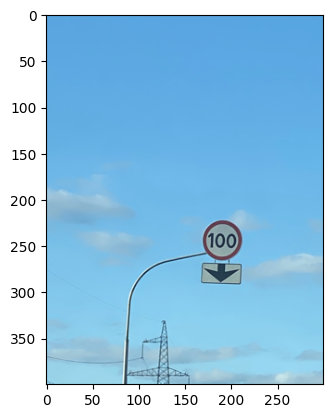

In [51]:
plt.imshow(img_src)
plt.show()


0: 224x192 1 speedlimit, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 192)


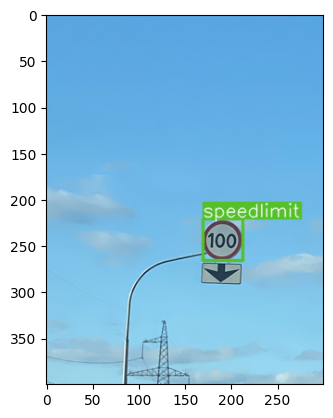

In [52]:
num_speedlimit = 0
num_stop = 0
num_crosswalk = 0
num_trafficlight = 0

test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

annotator = Annotator(img_src)
boxes = result.boxes

for box in boxes :
    b = box.xyxy[0]
    cls = box.cls

    if 'speedlimit' == model.names[int(cls)] :
        num_speedlimit += 1

    elif 'stop' == model.names[int(cls)] :
        num_stop += 1

    elif 'crosswalk' == model.names[int(cls)] :
        num_crosswalk += 1

    elif 'trafficlight' == model.names[int(cls)] :
        num_trafficlight += 1

    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

img_src = annotator.result()

# if num_speedlimit > 0 :
#     cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
#     cv2.putText(img_src, 'speedlimit', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
#                 thickness = 3, lineType = cv2.LINE_AA)

# elif num_stop > 0 :
#     cv2.rectangle(img_src, (0, 0), (300, 50), (0, 255, 0), -1, cv2.LINE_AA)
#     cv2.putText(img_src, 'stop', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
#                 thickness = 3, lineType = cv2.LINE_AA)

# elif num_crosswalk > 0 :
#     cv2.rectangle(img_src, (0, 0), (300, 50), (0, 0, 255), -1, cv2.LINE_AA)
#     cv2.putText(img_src, 'crosswalk', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
#                 thickness = 3, lineType = cv2.LINE_AA)

# elif num_trafficlight > 0 :
#     cv2.rectangle(img_src, (0, 0), (300, 50), (125, 125, 125), -1, cv2.LINE_AA)
#     cv2.putText(img_src, 'trafficlight', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
#                 thickness = 3, lineType = cv2.LINE_AA)

plt.imshow(img_src)
plt.show()


0: 160x224 1 stop, 18.2ms
Speed: 1.0ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 160, 224)

0: 224x192 1 speedlimit, 17.8ms
Speed: 0.9ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 38.1ms
Speed: 0.8ms preprocess, 38.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 35.4ms
Speed: 1.0ms preprocess, 35.4ms inference, 5.4ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 33.4ms
Speed: 1.0ms preprocess, 33.4ms inference, 14.1ms postprocess per image at shape (1, 3, 224, 192)

0: 224x192 1 speedlimit, 32.0ms
Speed: 2.3ms preprocess, 32.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 192)

0: 160x224 3 trafficlights, 39.1ms
Speed: 0.8ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 160, 224)

0: 224x192 1 crosswalk, 34.9ms
Speed: 1.0ms preprocess, 34.9ms inference, 4.9ms postprocess

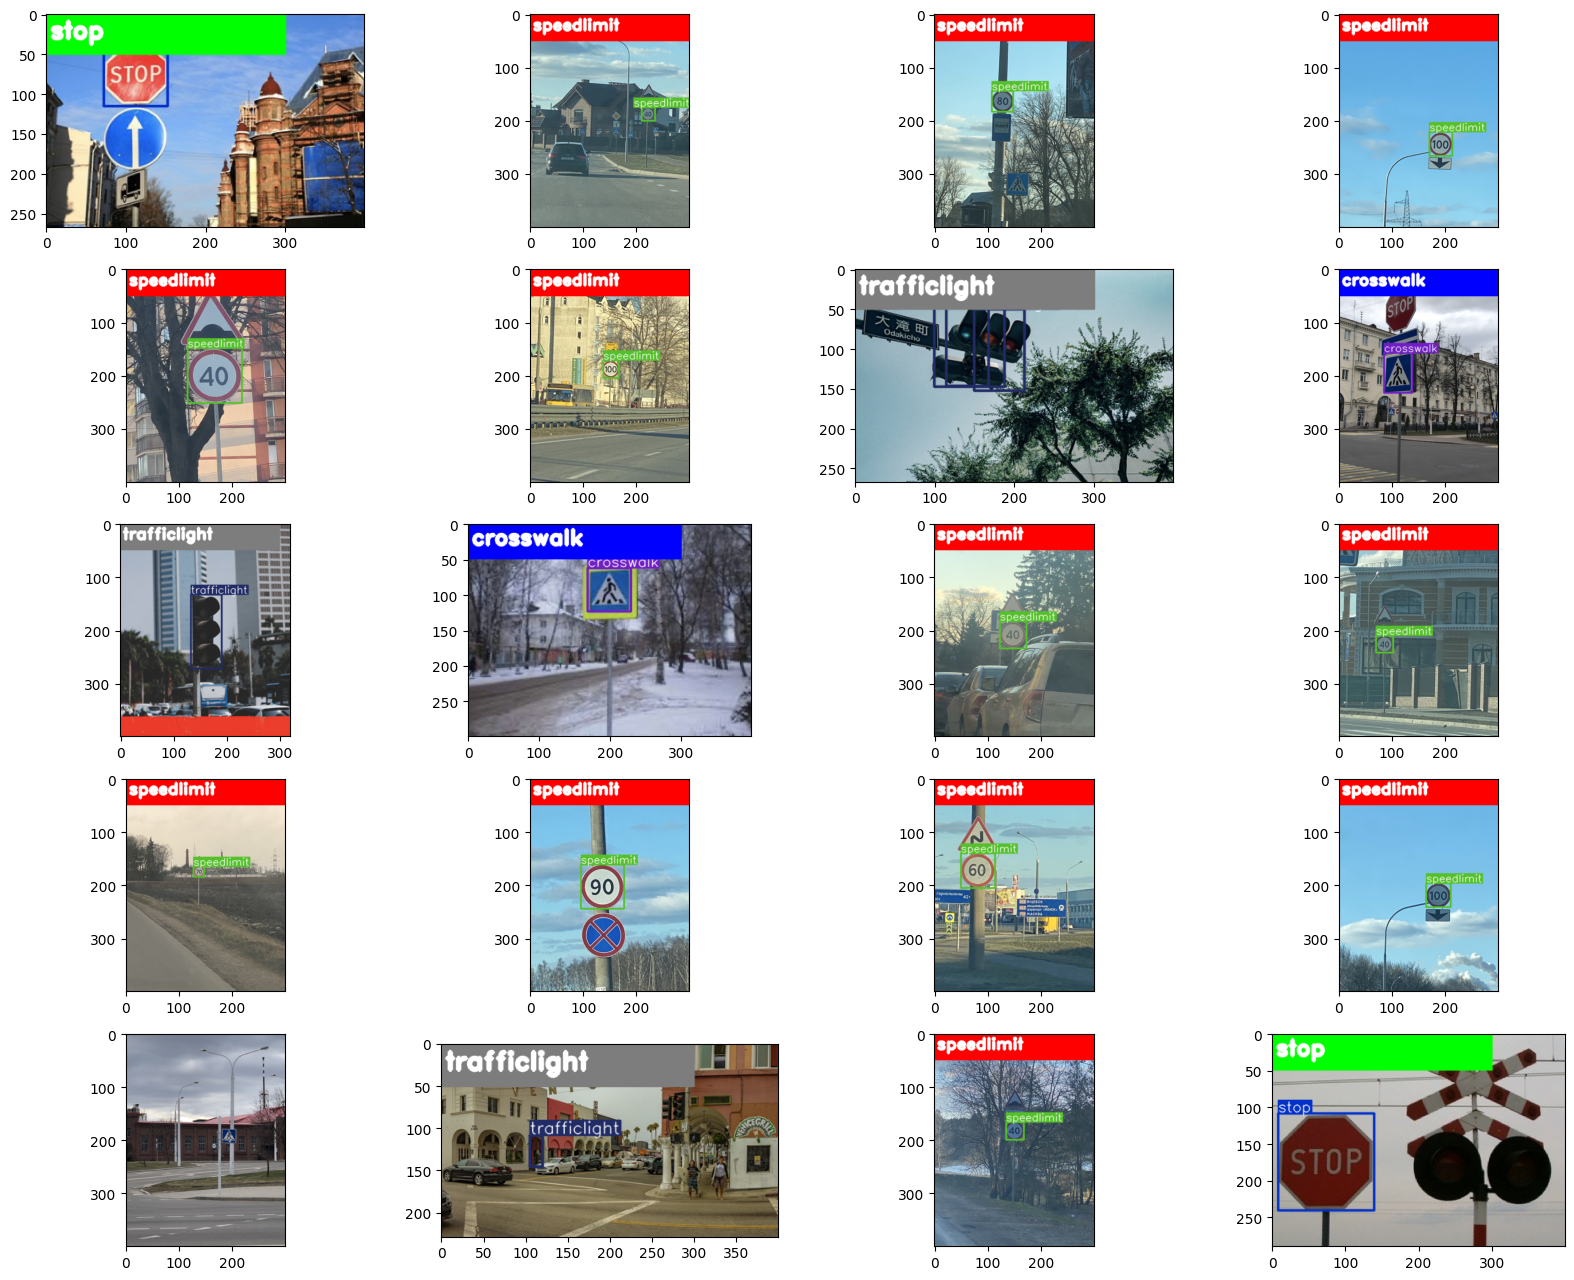

In [53]:
plt.figure(figsize = (20, 16))

for idx in range(20) :

    num_speedlimit = 0
    num_stop = 0
    num_crosswalk = 0
    num_trafficlight = 0

    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]

    annotator = Annotator(img_src)
    boxes = result.boxes

    for box in boxes :
        b = box.xyxy[0]
        cls = box.cls

        if 'speedlimit' == model.names[int(cls)] :
            num_speedlimit += 1

        elif 'stop' == model.names[int(cls)] :
            num_stop += 1

        elif 'crosswalk' == model.names[int(cls)] :
            num_crosswalk += 1

        elif 'trafficlight' == model.names[int(cls)] :
            num_trafficlight += 1

        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

    img_src = annotator.result()

    plt.subplot(5, 4, (idx + 1))

    if num_speedlimit > 0 :
        cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'speedlimit', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                    thickness = 3, lineType = cv2.LINE_AA)

    elif num_stop > 0 :
        cv2.rectangle(img_src, (0, 0), (300, 50), (0, 255, 0), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'stop', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                    thickness = 3, lineType = cv2.LINE_AA)

    elif num_crosswalk > 0 :
        cv2.rectangle(img_src, (0, 0), (300, 50), (0, 0, 255), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'crosswalk', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                    thickness = 3, lineType = cv2.LINE_AA)

    elif num_trafficlight > 0 :
        cv2.rectangle(img_src, (0, 0), (300, 50), (125, 125, 125), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'trafficlight', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                    thickness = 3, lineType = cv2.LINE_AA)

    plt.imshow(img_src)
plt.show()